# Neural Network Model Compression



---

## Overview of Singular Value Decomposition

We will be working on a problem involving singular value decomposition. Singular Value Decomposition (SVD) exists for every rectangular matrix. The nice thing about SVD is that the original matrix can be expressed as the sum of outer products of left and singular vectors scaled by the corresponding singular values. Formally:

> Let 𝛢 be a rectangular matrix of dimensions 𝑚𝘹𝑛, then the SVD of the matrix A is given by $ A = U𝛴V^T$ where $U$ is an orthogonal matrix of shape mxm containing the left singular vectors, $V$ is an orthogonal matrix of shape nxn containing the right singular vectors and $𝛴$ is a diagonal matrix containing the singular values of $A$. This formulation of SVD can be re-expressed as \begin{align} A = \sum_{i=1}^{r} s_i. u_i v_i^T \end{align} where $r = \text{min}(m,n)$ represents the rank of the matrix, $s_i$ is the $i$th singular value and $u_i v_i^T$ is the outer product of the $i$th left and right singular vectors. 

<!-- \begin{align}
A = \sum_{i=1}^{\text{min}(m,n)} s_i. u_i v_i^T
\end{align}
\begin{align} -->

> The singular values $𝛴$ are decreasing in order. So, each outer product is scaled by a smaller value as we compute each term in the sum above. This gives us an opportunity to approximate $A$ using only the sum of the first $k$ outer products where $k < \text{min}(m,n)$ $-$ this effectively means that we are zero-ing out some of the singular values by assuming that the contribution to the sum is negligible. This is called low-rank approximation.

If you aren't familiar with singular value decomposition, or the above feels rusty, don't worry. Take a moment to brush up your knowledge using any of the following resources:
* [stanford lecture notes on low rank approximations](https://web.stanford.edu/class/cs168/l/l9.pdf)
* [youtube series of short and beginner friendly lectures](https://www.youtube.com/watch?v=gXbThCXjZFM&list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv)



## Check for understanding (3 points)

### What are some real world applications of low rank approximations?
---
Low rank approximation is approximating the orignal data matrix using matrices of lower rank. This has several implications in terms of real world applications. Some of these applications are as follows:
- **Dense Word Embeddings**: SVD can be used to generate dense embeddings from spare PPMI(word-word matrices) and term-document matrices. These embeddings brings out some similarity between different words, which are close in terms of similarity.

- **Recommender Systems**: SVD gives us $3$ matrices which are $U, S, V$. Each of these matrices has some high-level explanation i.e. describes items or users. Taking dot product between two such vectors reveal the similarity between a user's choice and feature vector for movies. Hence, plays an important role in recommending, this idea is formally used in Collaborative Filtering.

- **Error Code Correction**: Low-Rank Approximation often helps us correct incorrect bits or complete corrupted bits in a stored data file by assuming the data matrix to be well-behaved.

- **Denoising Images and Financial Signal Processing**: High resolution image or tick level data of financial markets on various stocks can often degrade the performance of machine learning and deep learning models, because of the high variance of each observation due to noise that adds up only to details but not to the overall pattern. In such cases for pattern recognition, reducing the noisy dimensions through PCA helps.

- **Data and Image Compression**: If we have a data matrix(can be image matrix, tabular data, etc) which has dimensions $m\times n$, then the low-rank approximation (SVD) which has rank(say, $k << \min(m, n)$). Then the original matrix has a space complexity of $O(mn)$, whereas the approximate matrix has space complexity of $O(k(m+n))$. In most real world scenarios like images, choosing a moderate $k$(often quite less compared to $mn$) corresponding to the $k$ largest singular values is a good enough approximation.


### What are the benefits of compressing a deep neural network? How would you measure the benefits of compression?
---
Some of the benefits of compressing a deep neural network are:
- Deep Neural Networks are often memory intensive. **Compressing a DNN can help reduce the memory overhead for running these models**.
- Can possibly **speed up inference time** because of the sheer less time requires to compute the output of each layer.
- It can make it **possible to deploy these models on embedded systems and smaller devices with limited memory and computational constraints**.

The benefits stated above can be broadly classified into two categories i.e. memory requirements and inference time. So, the measures of the benefits of compression will be based on these two factors.
- The **inference time at different levels of compression** from low compression to maximum compression can be used as a metric to measure the efficacy of compression.
- The **memory requirement at different levels of compression** as stated above can be used as a measure.
- DNNs are often used for their performance over the other models. So, even though we optimize for the space and running time of these models. Accuaracy drops still remain a major concern for these models. So, observing the **drop in accuracy at various levels of compression** can help measure the benefits of compression.

### We will consider how singular value decomposition can be used to compress a deep neural network. Compared to other compression methods used for deep neural networks such as pruning, quantization, or efficient architectures, what are the relative merits/demerits of low rank approximations? 
---
Some merits of low rank approximation to compress deep neural networks over some of the other methods like pruning, quantization or efficient architectures are as follows:
- **Unstructured Pruning requires speacialized hardware and softwares to handle spare matrix multiplications and computations efficiently** compared to already existing hardware and software. But low rank approximation on the other hand can be computed efficiently on existing hardware.
- **Neural Architecture Search and Knowledge Distillation often requires setting multiple hyper-parameters and also requires training the smaller models again**. SVD on the other hand is much faster and simpler to implement.
- **Quantization focuses mostly on reducing the range of values the parameters of the neural network can take. Hence, it reduces the memory requirements of the neural network but does not have significant impact on the inference time**. But Low rank approximations help in optimizing both the memory requirement and inference time.
- **Quantization often runs in the issue of some hardwares not being able to handle computations for numbers of some particular sizes of bits**. Low rank approximation shines in that area of not having any dependency on hardware.
- **Retraining is necessary after the structed pruning or neuron unit pruning. This can prove to be quite harsh on performance sometimes, since a smaller model means a smaller capacity**. There is no such drawbacks with low rank approximation methods.

Although in various ways, which we saw above, low rank approximation outperforms the other methods. There are also demerits of using this technique over the others. Some of which we will see below:
- **Knowledge Distillation and Neural Architecture Search are quite flexible** methods and often when trained properly results is **superior results compared to low rank approximations**.
- **Knowledge Distillation and Neural Architechture Search can help take into account domain-dependent decision** which often proves fruitful in optimizing the model's accuracy and still achieving high level of compression. Whereas, there is no such decision that can be incorporated in SVD.



---



### Imports

In [ ]:
!pip install dm-haiku optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 350 kB 28.5 MB/s 
     |████████████████████████████████| 145 kB 67.5 MB/s 
     |████████████████████████████████| 85 kB 4.9 MB/s 


In [ ]:
from typing import Iterator, Mapping, Tuple
from copy import deepcopy
import time
from absl import app
import haiku as hk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
from functools import partial
import math

Batch = Tuple[np.ndarray, np.ndarray]



---




## SVD Low-Rank Approximation of Neural Network 


We are now going to explore using SVD to compute low rank approximations of the parameters of a small deep neural network. We are using a very simple toy model as a first baseline. 

In [ ]:
# The means and the standard deviation of the channels to be used for normalizing each channel of the input images as a preprocessing step
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)


def net_fn(batch: Batch) -> jnp.ndarray:
  """
  :description:
    passes the batch of input features through the network and generates output

  :arguments:
    batch: a tuple of the form (nd.array, nd.array), where first element is the input features and second element is the target label

  :output:
    returns nd.array of shape (batch.shape[0], 10), where 10 corresponds to the logit prediction of the model for each of the 10 target classes for a particular input features
  """

  # normalization of each image as a preprocessing step
  x = normalize(batch[0])
  
  net = hk.Sequential([
      hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      hk.Flatten(),
      hk.Linear(3000), jax.nn.relu,
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(1000), jax.nn.relu,
      hk.Linear(10),
  ])
  return net(x)

def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
) -> Iterator[tuple]:
  """
  :description:
    loads the CIFAR10 dataset as a generator of batches.

  :arguments:
    split: a string as per tensorflow datasets guidelines for obtaining a portion of or full train or test split of CIFAR10 dataset.
    is_training: if True shuffles the dataset, o.w. does not shuffle the dataset.
    batch_size: the number of input features to be generated in each yield of the dataset generator. 
  
  :output:
    return a generator which yields batch_size many features and labels.
  """
  ds = tfds.load('cifar10', split=split, as_supervised=True).cache().repeat()
  if is_training:
    ds = ds.shuffle(10 * batch_size, seed=0)
  ds = ds.batch(batch_size)
  return iter(tfds.as_numpy(ds))

def compute_loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
  """
  :description:
    compute the cross-entropy loss of the network for 10 classes and L2 regularization with 1e-4 regularization coefficient 
    for its prediction on a given batch, including L2 regularization.
  
  :arguments:
    params: parameters of the haiku model.
    batch: batch of input features and labels.

  :output:
    returns scalar value corresponding to the loss.
  """
  x, y = batch
  batch_size = x.shape[0] # Batch Size
  logits = net.apply(params, batch)
  labels = jax.nn.one_hot(y, 10)

  l2_loss = sum([jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params)])
  weighted_l2_loss = 0.5 * l2_loss
  
  # Cost Function is the average of the loss over the batch
  softmax_xent = optax.softmax_cross_entropy(logits=logits, labels=labels).mean()

  # The regularizer is added to the overall cross-entropy loss
  return softmax_xent + (1e-4 * weighted_l2_loss) 


@jax.jit
def compute_accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
  """
  :description:
    finds the accuracy of a model on a batch by generating outputs of the model on the input features in the batch
    and finding how many of them matches with the ground truth.
  
  :arguments:
    params: parameters of the haiku model.
    batch: batch of input features and labels.

  :output:
    returns scalar value corresponding to the accuracy
  """

  x, y = batch
  predictions = net.apply(params, batch)

  accuracy = jnp.mean(jnp.argmax(predictions, axis=-1) == y)
  return accuracy

@jax.jit
def update(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
) -> Tuple[hk.Params, optax.OptState]:
  """
  :description:
    updates the parameters of the model based on the chosen optimizer through 
    back propagating the loss using gradients
  
  :arguments:
    params: parameters of the haiku model.
    opt_state: optax optimizer's state.
    batch: batch of input features and labels.

  :output:
    returns a tuple of new updated parameter and new updated optimizer's state
  """
  grads = jax.grad(compute_loss)(params, batch)
  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, opt_state

@jax.jit
def ema_update(params, avg_params):
  """
  :description:
    updates the exponential moving average parameters of the model, where a fraction 
    of the new parameter values is added to the average parameters value.
  
  :arguments:
    params: parameters of the haiku model.
    avg_params: previous exponential moving averaged parameters of the haiku model.

  :output:
    returns the updated exponential moving average parameters of the model.
  """
  return optax.incremental_update(params, avg_params, step_size=0.001)


def normalize(images):
  """
  :description:
    Normalizes and changes the value from unsigned int8 to float each channel 
    of the input image array based on the CIFAR10 preprocessing steps
  
  :arguments:
    images: a 4D tensor containing all images of a batch i.e. each image has height, width and channel.

  :output:
    returns the normalized image 4D tensor.
  """
  mean = jnp.asarray(CIFAR10_MEAN)
  std = jnp.asarray(CIFAR10_STD)
  x = images.astype(jnp.float32) / 255.
  x -= mean # Previously it was a type x /- mean, changed it to x -= mean
  x /= std

  return x

### Training

In [ ]:
# The Net and the Optimizer.
net = hk.without_apply_rng(hk.transform(net_fn))

# Do not change learning rate.
opt = optax.adam(1e-3)

# Loading the Datasets.

# The training set is 80% of the CIFAR10 train split and with smaller batch size.
train = load_dataset("train[0%:80%]", is_training=True, batch_size=32)

# The validation set is 20% of the CIFAR10 train split.
validation = load_dataset("train[80%:]", is_training=False, batch_size=10000)

# The test set is the entire CIFAR10 test split.
test = load_dataset("test", is_training=False, batch_size=10000)

# Initializing the weights and biases of the Net.
params = avg_params = net.init(jax.random.PRNGKey(42), next(train))

# Initializing the optimizer state.
opt_state = opt.init(params)

# Training the network for 10000 steps and displays evaluation metric after each 1000 steps.
for step in range(10001):
  if step % 1000 == 0:
    # Evaluation Metrics on Validation and Test Set.
    val_accuracy = compute_accuracy(avg_params, next(validation))
    test_accuracy = compute_accuracy(avg_params, next(test))
    val_accuracy, test_accuracy = jax.device_get(
        (val_accuracy, test_accuracy))
    print(f"[Step {step}] Validation / Test accuracy: "
          f"{val_accuracy:.3f} / {test_accuracy:.3f}.")
  # Update the parameters of the model and maintain the exponential smoothing average of the parameters.
  params, opt_state = update(params, opt_state, next(train))
  avg_params = ema_update(params, avg_params)

# Running the notebook multiple times yields different values for the Test accuracy, which is usually in the range of 0.658 to 0.67
# which has to do with the random initialization of the model parameters.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incomplete7683QN/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incomplete7683QN/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
[Step 0] Validation / Test accuracy: 0.101 / 0.103.
[Step 1000] Validation / Test accuracy: 0.393 / 0.393.
[Step 2000] Validation / Test accuracy: 0.549 / 0.546.
[Step 3000] Validation / Test accuracy: 0.614 / 0.609.
[Step 4000] Validation / Test accuracy: 0.651 / 0.649.
[Step 5000] Validation / Test accuracy: 0.662 / 0.662.
[Step 6000] Validation / Test accuracy: 0.666 / 0.668.
[Step 7000] Validation / Test accuracy: 0.663 / 0.668.
[Step 8000] Validation / Test accuracy: 0.656 / 0.663.
[Step 9000] Validation / Test accuracy: 0.658 / 0.663.
[Step 10000] Validation / Test accuracy: 0.657 / 0.658.


## Compression through Low Rank Approximation

In this section, you will add code to compute the low rank approximation and to compute evaluation metrics. We will evaluate whether the low rank approximation allows for speed up in inference time. We define inference time as the average time to compute the prediction for all examples in the test set.


In [ ]:
def compute_eval_metrics(params, batch, n_samples):
  """
  :description:
    computes the evaluation metric i.e. accuracy and inference time for a number of times on the given batch.
  
  :arguments:
    params: parameters of the haiku model.
    batch: batch of input features and labels.
    n_samples: number of times inference will be run on the given batch.

  :output:
    returns two lists of accuracy and inference times appended in the list for n_sample many times.
  """
  duration_list = []
  accuracy_list = []
  for _ in range(n_samples):
    start = time.time()
    acc = compute_accuracy(params, batch)
    end = time.time()
    duration = end - start
    duration_list.append(duration)
    accuracy_list.append(acc)

  return accuracy_list, duration_list

In [ ]:
def rank_approximated_weight(weight: jnp.ndarray, rank_fraction: float):
  """
  :description:
    computes the svd of the weight matrix and produces U and Vh matrices which are truncted using rank fraction.
  
  :arguments:
    weight: weights associated with a particular layer.
    rank_fraction: the fraction of the original matrix rank which is to be kept.

  :output:
    returns two truncated matrices u and vh.
  """
  u, s, v = jnp.linalg.svd(weight, full_matrices = False)
  size = int(weight.shape[1] * rank_fraction)
  u = u[:,:size] * s[:size]
  v = v[:size,:]

  return u, v

### Evaluations at different ranks

The code below first replaces the weights with the low rank factorizations at different rank fractions. For each modified net, we compute the new eval accuracy.

In [ ]:
rank_truncated_params = deepcopy(params)
ranks_and_accuracies = []
ranks_and_times = []

# evaluating model performance and inference time at various levels of rank fraction i.e. compression
for rank_fraction in np.arange(1.0, 0.0, -0.1):

  print(f"Evaluating the model at {rank_fraction}")
  for layer in params.keys():
    if 'conv' in layer:
      continue
    weight = params[layer]['w']
    u, v = rank_approximated_weight(weight, rank_fraction)
    rank_truncated_params[layer]['w'] = u@v

  test_batch = next(test)
  # we compute metrics over 50 samples to reduce noise in the measurement.
  n_samples = 50
  test_accuracy, latency = compute_eval_metrics(rank_truncated_params, next(test), n_samples)
  print(f"Rank Fraction / Test accuracy: "
          f"{rank_fraction:.2f} / {np.mean(test_accuracy):.3f}.")
  ranks_and_accuracies.append((rank_fraction, np.mean(test_accuracy)))
  print(f"Rank Fraction / Duration: "
          f"{rank_fraction:.2f} / {np.mean(latency):.4f}.")
  ranks_and_times.append((rank_fraction, np.mean(latency)))

Evaluating the model at 1.0
Rank Fraction / Test accuracy: 1.00 / 0.620.
Rank Fraction / Duration: 1.00 / 0.0884.
Evaluating the model at 0.9
Rank Fraction / Test accuracy: 0.90 / 0.620.
Rank Fraction / Duration: 0.90 / 0.0880.
Evaluating the model at 0.8
Rank Fraction / Test accuracy: 0.80 / 0.622.
Rank Fraction / Duration: 0.80 / 0.0878.
Evaluating the model at 0.7000000000000001
Rank Fraction / Test accuracy: 0.70 / 0.620.
Rank Fraction / Duration: 0.70 / 0.0885.
Evaluating the model at 0.6000000000000001
Rank Fraction / Test accuracy: 0.60 / 0.560.
Rank Fraction / Duration: 0.60 / 0.0877.
Evaluating the model at 0.5000000000000001
Rank Fraction / Test accuracy: 0.50 / 0.513.
Rank Fraction / Duration: 0.50 / 0.0880.
Evaluating the model at 0.40000000000000013
Rank Fraction / Test accuracy: 0.40 / 0.486.
Rank Fraction / Duration: 0.40 / 0.0882.
Evaluating the model at 0.30000000000000016
Rank Fraction / Test accuracy: 0.30 / 0.500.
Rank Fraction / Duration: 0.30 / 0.0882.
Evaluating 

### What do you observe as the relationship between rank fraction and test accuracy?

Plot this relationship showing accuracy (y-axis) vs rank percentage of the matrix (x-axis).

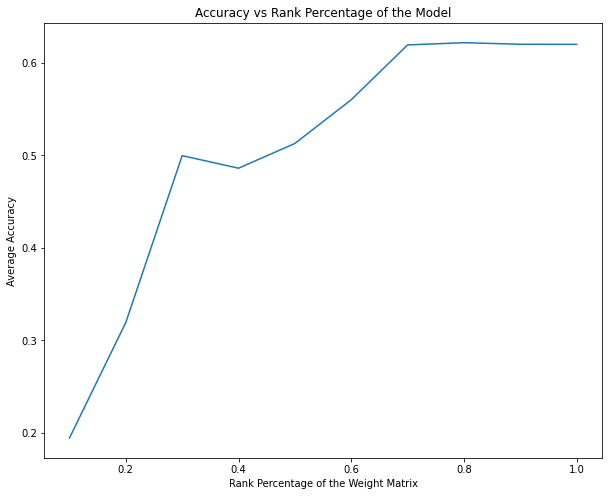

In [ ]:
## TODO: add your code below to plot the relationship between time and test set accuracy
plt.figure(figsize=(10,8))
plt.plot([rank for rank, _ in ranks_and_accuracies], [acc for _, acc in ranks_and_accuracies])
plt.xlabel('Rank Percentage of the Weight Matrix')
plt.ylabel('Average Accuracy')
plt.title('Accuracy vs Rank Percentage of the Model')
plt.show()

### Does replacing the weight matrix with the low factor matrix result in latency speed ups?

Plot the relationship of time (y-axis) vs rank percentage (x-axis).

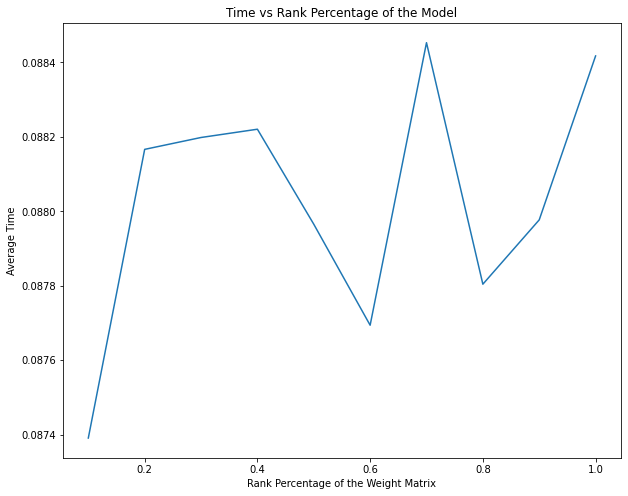

In [ ]:
plt.figure(figsize=(10,8))
plt.plot([rank for rank, _ in ranks_and_times], [tim for _, tim in ranks_and_times])
plt.xlabel('Rank Percentage of the Weight Matrix')
plt.ylabel('Average Time')
plt.title('Time vs Rank Percentage of the Model')
plt.show()

## Perform evaluations on the dataset in factorized space.

In this section, we will perform evaluations on the dataset in factorized space.

In [ ]:
def low_rank_net_fn(batch: Batch, rank: float) -> jnp.ndarray:
  """
  :description:
    passes the batch of input features through the low rank network and generates output

  :arguments:
    batch: a tuple of the form (nd.array, nd.array), where first element is the input features and second element is the target label

  :output:
    nd.array of shape (batch.shape[0], 10), where 10 corresponds to the logit prediction of the model for each of the 10 target classes for a particular input features
  """
  
  x = normalize(batch[0])
  total_input_dim = np.prod(x.shape[1:])
  
  net = hk.Sequential([
      hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      hk.Flatten(),
      hk.Linear(int(rank * min(total_input_dim, 3000)), with_bias=False),
      hk.Linear(3000), jax.nn.relu,
      hk.Linear(int(rank * 2000), with_bias=False), 
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(int(rank * 2000), with_bias=False), 
      hk.Linear(2000), jax.nn.relu,      
      hk.Linear(int(rank * 1000), with_bias=False), 
      hk.Linear(1000), jax.nn.relu,
      hk.Linear(int(rank * 10), with_bias=False),
      hk.Linear(10),
  ])
  return net(x)

In [ ]:
# SVD reduced model architecture
vanilla_to_low_rank_map = {
    'conv2_d': 'conv2_d',
    'conv2_d_1': 'conv2_d_1',
    'linear': ['linear', 'linear_1'],
    'linear_1': ['linear_2', 'linear_3'],
    'linear_2': ['linear_4', 'linear_5'],
    'linear_3': ['linear_6', 'linear_7'],
    'linear_4': ['linear_8', 'linear_9']
}


ranks_and_accuracies = []
ranks_and_times = []

for rank_fraction in np.arange(1.0, 0.0, -0.1):
  low_rank_net_fn_partial = partial(low_rank_net_fn, rank=rank_fraction)
  net = hk.without_apply_rng(hk.transform(low_rank_net_fn_partial)) 
  low_rank_params = net.init(jax.random.PRNGKey(42), next(train))

  print(f"Evaluating the model at" f"{rank_fraction:.2f}")

  for layer in vanilla_to_low_rank_map.keys():
    if 'conv' in layer:
      low_rank_params[layer] = params[layer]
      continue
    weight = params[layer]['w']
    
    u, v = rank_approximated_weight(weight, rank_fraction)
    low_rank_params[vanilla_to_low_rank_map[layer][0]]['w'] = u
    low_rank_params[vanilla_to_low_rank_map[layer][1]]['w'] = v
    low_rank_params[vanilla_to_low_rank_map[layer][1]]['b'] = params[layer]['b']

  test_accuracy, duration = compute_eval_metrics(low_rank_params, next(test), 50)
  ranks_and_times.append((rank_fraction, np.mean(duration)))
  ranks_and_accuracies.append((rank_fraction, np.mean(test_accuracy)))
  print(f"Rank Fraction / Test accuracy: "
          f"{rank_fraction:.2f} / {np.mean(test_accuracy):.3f}.")
  print(f"Rank Fraction / Duration: "
          f"{rank_fraction:.2f} / {np.mean(duration):.4f}.")

Evaluating the model at1.00
Rank Fraction / Test accuracy: 1.00 / 0.620.
Rank Fraction / Duration: 1.00 / 0.2689.
Evaluating the model at0.90
Rank Fraction / Test accuracy: 0.90 / 0.620.
Rank Fraction / Duration: 0.90 / 0.2790.
Evaluating the model at0.80
Rank Fraction / Test accuracy: 0.80 / 0.622.
Rank Fraction / Duration: 0.80 / 0.2513.
Evaluating the model at0.70
Rank Fraction / Test accuracy: 0.70 / 0.620.
Rank Fraction / Duration: 0.70 / 0.2328.
Evaluating the model at0.60
Rank Fraction / Test accuracy: 0.60 / 0.560.
Rank Fraction / Duration: 0.60 / 0.2101.
Evaluating the model at0.50
Rank Fraction / Test accuracy: 0.50 / 0.513.
Rank Fraction / Duration: 0.50 / 0.1891.
Evaluating the model at0.40
Rank Fraction / Test accuracy: 0.40 / 0.486.
Rank Fraction / Duration: 0.40 / 0.1790.
Evaluating the model at0.30
Rank Fraction / Test accuracy: 0.30 / 0.500.
Rank Fraction / Duration: 0.30 / 0.1558.
Evaluating the model at0.20
Rank Fraction / Test accuracy: 0.20 / 0.319.
Rank Fraction /

### Q6: Plot a curve showing time vs rank percentage of the matrix 

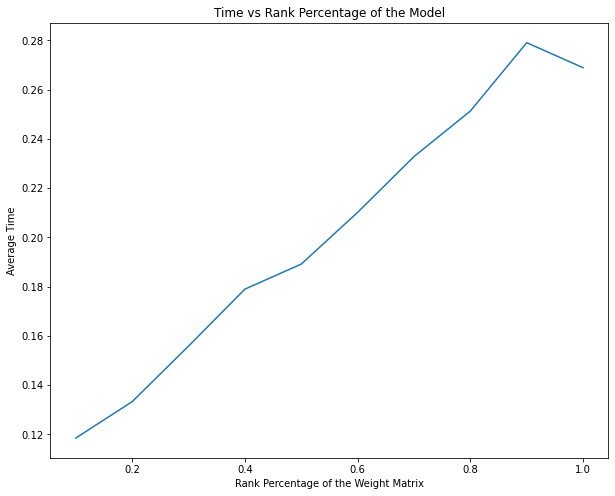

In [ ]:
# TODO: add code to plot the relationship between time vs percentage rank of the matrix.
plt.figure(figsize=(10,8))
plt.plot([rank for rank, _ in ranks_and_times], [tim for _, tim in ranks_and_times])
plt.xlabel('Rank Percentage of the Weight Matrix')
plt.ylabel('Average Time')
plt.title('Time vs Rank Percentage of the Model')
plt.show()

### What do you observe between time and the percentage rank of the matrix.

It is seen as expected that, as the rank fraction of the matrix increases the inference time increases because the number of multiplications to be carried out is now more. But this comes at the cost of accuracy drop.



---



## Magnitude-Based Pruning of Neural Network



In [ ]:
"""
Below I implement Pruning of Neural Network instead of SVD to achieve results even better than SVD
"""

'\nBelow I implement Pruning of Neural Network instead of SVD to achieve results even better than SVD\n'

In [ ]:
def prune_weight(weight: jnp.ndarray, prune_fraction: float) -> jnp.ndarray:
  """
  description:
    prunes the smallest prune_fraction % of values in weight i.e. sets them to 0
  
  arguments:
    weight: weight matrix that needs to be pruned
    prune_fraction: a value between 0 and 1 that represents what percentage of weights need to be pruned

  output:
    returns the same matrix as weight with lowest prune_fraction % values set to 0
  """
  # reshape the weights to find the smallest prune_fraction weights in magnitude
  weight_reshape = jnp.reshape(weight, -1)
  # number of weights to be pruned
  num_prunes = int(prune_fraction * np.prod(weight.shape))
  # the indices of the weights to be pruned
  _, prune_idx = jax.lax.top_k(-jnp.abs(weight_reshape), num_prunes)
  # create a mask to make the pruned weights to be 0
  mask = jnp.ones_like(weight_reshape)
  mask = mask.at[prune_idx].set(0)
  # return the pruned weights
  return jnp.reshape(weight_reshape*mask, weight.shape)

In [ ]:
def prune_net(params: hk.Params, prune_fraction: float):
  """
  description:
    prunes the weights of the network except the weights of the convolutional layers
  
  arguments:
    params: parameters of the network to be pruned
    prune_fraction: fraction of weights in each layer that would be pruned

  output:
    modifies the pruned_params(hk.Params) dictionary which is the deepcopy of original network params
    to store the pruned weights
  """
  for layer in params.keys():
    if 'conv' in layer:
      pruned_params[layer] = params[layer]
      continue
    pruned_params[layer]['w'] = prune_weight(params[layer]['w'], prune_fraction)

In [ ]:
pruned_params = deepcopy(params) # copy the parameters of the original unpruned network

# stores the evaluation metric of accuracy and inference time
prune_fracs_and_accuracies = [] 
prune_fracs_and_times = []

# evaluating model performance and inference time at various levels of prune fraction
for prune_fraction in np.arange(0.0, 1.1, 0.1):
  prune_net(params, prune_fraction) # pruning the network

  test_accuracy, duration = compute_eval_metrics(pruned_params, next(test), 50)
  prune_fracs_and_times.append((prune_fraction, np.mean(duration)))
  prune_fracs_and_accuracies.append((prune_fraction, np.mean(test_accuracy)))
  print(f"Prune Fraction / Test accuracy: "
            f"{prune_fraction:.2f} / {np.mean(test_accuracy):.3f}.")
  print(f"Prune Fraction / Duration: "
            f"{prune_fraction:.2f} / {np.mean(duration):.4f}.")

Prune Fraction / Test accuracy: 0.00 / 0.620.
Prune Fraction / Duration: 0.00 / 0.0879.
Prune Fraction / Test accuracy: 0.10 / 0.620.
Prune Fraction / Duration: 0.10 / 0.0865.
Prune Fraction / Test accuracy: 0.20 / 0.620.
Prune Fraction / Duration: 0.20 / 0.0873.
Prune Fraction / Test accuracy: 0.30 / 0.620.
Prune Fraction / Duration: 0.30 / 0.0874.
Prune Fraction / Test accuracy: 0.40 / 0.620.
Prune Fraction / Duration: 0.40 / 0.0862.
Prune Fraction / Test accuracy: 0.50 / 0.620.
Prune Fraction / Duration: 0.50 / 0.0860.
Prune Fraction / Test accuracy: 0.60 / 0.621.
Prune Fraction / Duration: 0.60 / 0.0858.
Prune Fraction / Test accuracy: 0.70 / 0.621.
Prune Fraction / Duration: 0.70 / 0.0851.
Prune Fraction / Test accuracy: 0.80 / 0.621.
Prune Fraction / Duration: 0.80 / 0.0839.
Prune Fraction / Test accuracy: 0.90 / 0.621.
Prune Fraction / Duration: 0.90 / 0.0828.
Prune Fraction / Test accuracy: 1.00 / 0.100.
Prune Fraction / Duration: 1.00 / 0.0785.


### Accuracy vs Pruned Fraction Plot

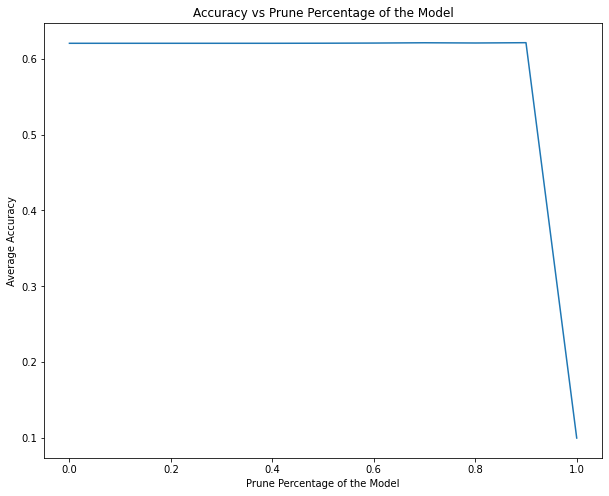

In [ ]:
plt.figure(figsize=(10,8))
plt.plot([prune_frac for prune_frac, _ in prune_fracs_and_accuracies], [acc for _, acc in prune_fracs_and_accuracies])
plt.xlabel('Prune Percentage of the Model')
plt.ylabel('Average Accuracy')
plt.title('Accuracy vs Prune Percentage of the Model')
plt.show()

$1$ prune percentage means $100\%$ of the weights have been pruned or set to $0$, whereas $0$ prune percentage means none of the weights have been pruned.

### Inference Time vs Pruned Fraction Plot

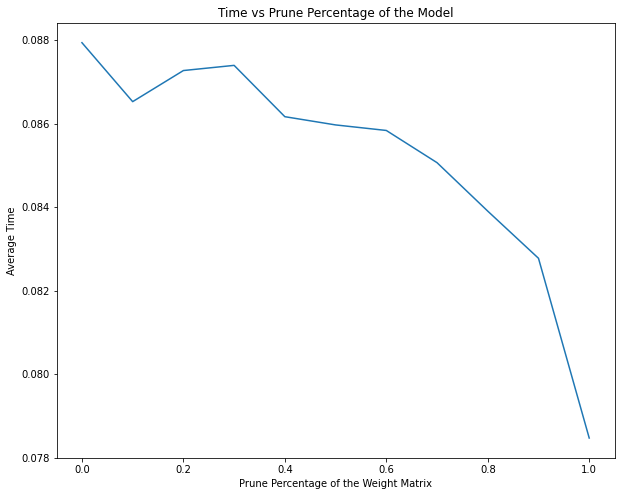

In [ ]:
plt.figure(figsize=(10,8))
plt.plot([prune_frac for prune_frac, _ in prune_fracs_and_times], [tim for _, tim in prune_fracs_and_times])
plt.xlabel('Prune Percentage of the Weight Matrix')
plt.ylabel('Average Time')
plt.title('Time vs Prune Percentage of the Model')
plt.show()

$1$ prune percentage means $100\%$ of the weights have been pruned or set to $0$, whereas $0$ prune percentage means none of the weights have been pruned.

### Conclusion

We see a reduction in inference time compared to SVD, with more accuracy preserved. We can get much lower inference time on specialized hardware meant for sparse matrix computations. It is very interesting to see that even after $90\%$ weights being pruned the network's accuracy doesn't drop, which is a good hint towards the direction that a smarter pruning compared to simple magnitude based pruning can be far more effective in letting us prune to a greater extent.